0. Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


1. Importations

In [ ]:
import warnings
warnings.filterwarnings("ignore")

2. Utils 

In [ ]:
def load (path) : 
  df = pd.read_csv(path)
  return df 

In [ ]:
def non_numerical_features (df_games) : 
  numerical = df_games.dtypes[df_games.dtypes != "object"].index
  non_num = []
  for x in  list(df_games.columns) : 
      if x not in numerical : 
          non_num.append(x)
  return non_num

3.Loading Data

In [ ]:
import pandas as pd
df_games = load ('/content/gdrive/MyDrive/Kaggle/basket_ball.csv')

In [ ]:
useful_features = ['WL_HOME','TEAM_ABBREVIATION_HOME','SERIES_LEADER',
'TEAM_NAME_HOME','HISTORICAL_STATUS',
'GAME_DATE',
'MATCHUP_HOME',
'TEAM_ABBREVIATION_AWAY',
'TEAM_NAME_AWAY',
'GAME_DATE_EST',
'GAME_STATUS_TEXT',
'SEASON',
'TEAM_CITY_AWAY',
'TEAM_CITY_HOME',
'ATTENDANCE',
'TEAM_CITY_NAME_HOME',
'TEAM_CITY_NAME_AWAY',
'TEAM_NICKNAME_AWAY',
'TEAM_NICKNAME_HOME',
'LAST_GAME_HOME_TEAM_POINTS',
'LAST_GAME_HOME_TEAM_CITY',
'LAST_GAME_HOME_TEAM_NAME',	
'LAST_GAME_HOME_TEAM_ABBREVIATION',
'LAST_GAME_VISITOR_TEAM_CITY',
'LAST_GAME_VISITOR_TEAM_CITY1',
'LAST_GAME_VISITOR_TEAM_POINTS']

Tajzir Data

In [ ]:
df_games = df_games[df_games.SEASON >= 2009]
df_games = df_games[useful_features]

In [ ]:
df_games = df_games.dropna(how='any')

5. Nans 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def missing_values(df): 
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of Missing Values', fontsize=15)
  plt.title('Percentage of Missing Data by Feature', fontsize=15)
  # missing_data.head()
  return (missing_data)

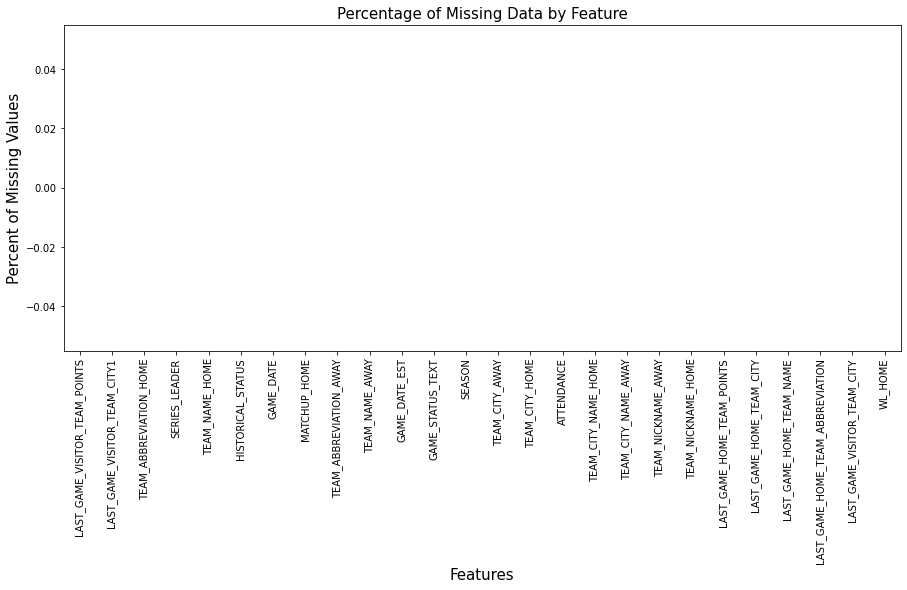

In [ ]:
missing_data = missing_values(df_games)

6. Converting 

In [ ]:
def convert_home(x):
  if x == "L": return 0
  else : return 2

In [ ]:
df_games['WL_HOME'] = df_games['WL_HOME'].apply(convert_home)

In [ ]:
df_games.shape

(13464, 26)

7. Splitting 

In [ ]:
def splitting_data (df_games):
  df_games = df_games.sample(frac=1).reset_index(drop=True)
  train,test = df_games[:12000] , df_games[12000:]
  return train,test

In [ ]:
train,test = splitting_data (df_games)

Modeling

In [ ]:
non_num = non_numerical_features (df_games)

In [ ]:
class CFG_Catboost :
  SEED = 42
  n_splits = 5
  catboost_params = {'learning_rate':0.05,'iterations':10000,'eval_metric':'AUC',
                      'use_best_model' :True,'verbose':100,'random_seed': 0,}
  remove_features = ['WL_HOME']
  categ_features = non_num
  TARGET_COL = 'WL_HOME'

In [ ]:
def features_utils (train):
  features_columns = [col for col in train.columns if col not in CFG_Catboost.remove_features]
  return features_columns

In [ ]:
features_columns = features_utils (train)

In [ ]:
def divide_train (train):
  skf = StratifiedKFold(n_splits=CFG_Catboost.n_splits,shuffle=True, random_state=CFG_Catboost.SEED)
  X , y   = train[features_columns] , train[CFG_Catboost.TARGET_COL]
  return X,y,skf

In [ ]:
from sklearn.model_selection import StratifiedKFold
X,y,skf= divide_train (train)

In [ ]:
def StratifiedKFold_Train(X,y):
  # oof_cat = np.zeros((train.shape[0],))
  test['target'] = 0
  cat_preds= []
  for fold_, (trn_idx, val_idx) in enumerate(skf.split(X,y)):
      print(50*'-')
      print('Fold:',fold_+1)
      X_train, y_train = X.iloc[trn_idx,:], y[trn_idx] 
      X_test, y_test = X.iloc[val_idx,:], y[val_idx] 
        
      estimator = CatBoostClassifier(**CFG_Catboost.catboost_params)
      estimator.fit(Pool(X_train,y_train,cat_features = CFG_Catboost.categ_features),
                    eval_set = Pool(X_test,y_test,cat_features = CFG_Catboost.categ_features),
                    early_stopping_rounds=200)
      
      # y_pred_val = estimator.predict(X_test)
      # oof_cat[val_idx] = y_pred_val
      y_pred_test = estimator.predict(test[features_columns])
      cat_preds.append(y_pred_test)
      print(50*'-')
      print()
  catboost_preds = np.mean(cat_preds,axis=0)
  return catboost_preds


In [ ]:
!pip install catboost==0.22 --quiet


     |████████████████████████████████| 64.4 MB 9.1 kB/s 


In [ ]:
from catboost import CatBoostClassifier ,Pool
import numpy as np
catboost_preds = StratifiedKFold_Train(X,y)

--------------------------------------------------
Fold: 1
0:	test: 0.8501905	best: 0.8501905 (0)	total: 110ms	remaining: 18m 18s
100:	test: 0.8785714	best: 0.8787026 (98)	total: 5.56s	remaining: 9m 5s
200:	test: 0.8811032	best: 0.8811032 (200)	total: 10.8s	remaining: 8m 46s
300:	test: 0.8816571	best: 0.8817080 (222)	total: 16.3s	remaining: 8m 46s
400:	test: 0.8815503	best: 0.8818047 (390)	total: 21.9s	remaining: 8m 45s
500:	test: 0.8808531	best: 0.8818047 (390)	total: 27.6s	remaining: 8m 42s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8818047423
bestIteration = 390

Shrink model to first 391 iterations.
--------------------------------------------------

--------------------------------------------------
Fold: 2
0:	test: 0.8636877	best: 0.8636877 (0)	total: 40.7ms	remaining: 6m 46s
100:	test: 0.8988699	best: 0.8988699 (100)	total: 5.42s	remaining: 8m 51s
200:	test: 0.9001597	best: 0.9001741 (196)	total: 11.1s	remaining: 8m 59s
300:	test: 0.9006384	best: 0.9006

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.asarray(catboost_preds).astype('int32'),test['WL_HOME'])


0.8046448087431693